In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.style.use('ggplot')
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
from IPython import display
from collections import deque, namedtuple
import pickle
import control
from ExtKalmanFilter import *
from ppo import PPO
from DynamicModels.DynamicsFixedGain import *
from sqrtm import sqrtm
from Utilities import rewardFunction#, Cov2Vec, Vec2Cov
torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deviceCPU = torch.device("cpu")
print(device, deviceCPU)

cpu cpu


In [2]:
# Figures parameters
saveFigs = True
FigDim1 = 3.0
FigDim2 = 1.5
# Noise parameters Cov(w), Cov(v), respectively
Q = 1 * torch.diag(1.0 * torch.ones(rx,))
#Q[2:5,2:5] = 0.05 * torch.diag(1.0 * torch.ones(rx-2,))
Q_true = Q*0.1
#Q_true[3:6,3:6] = 0.0
R = 2 * torch.diag(1.0 * torch.ones(ry,))
# Dimensions
# LQR control in the Certainty Equivalence case
A = f_Jacobian(torch.zeros(rx, 1), torch.zeros(ru, 1)) #Linearization about 0
Q_lqr = torch.diag(1.0 * torch.ones(rx,))
#Q_lqr[2:5,2:5] = 0.0
R_lqr = torch.diag(1.0 * torch.ones(ru,))
#Klqr, _, _ = control.dlqr(A, torch.tensor([[1]]), Q_lqr, R_lqr)
# Define model: dynamics, dynamics gradients, and noise covariances.
model = Model(stateDynamics, measurementDynamics, f_Jacobian, g_Jacobian, Q, R)
# Define information state: (mean, covariance), from an extended Kalman Fitler.
x0=torch.randn(rx, 1)
P0=torch.diag(torch.ones(rx,))
Hyperstate = Extended_KF(x0, P0, model)
Hyperstate.printem()

x_{k|k}=  tensor([[0.8618]]) \Sigma_{k|k}=  tensor([[1.]])


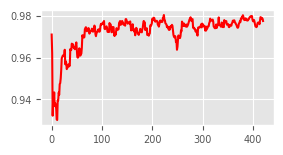

KeyboardInterrupt: 

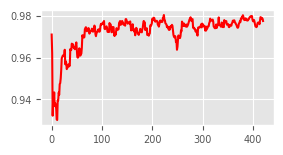

In [3]:
hidden_dim = 64
actor_lr = 1e-4# * 10
val_lr = actor_lr * 10
Horizon_Length = 8
RollOuts = 8
gamma = 0.95
max_stageCost = 1e3
action_std = torch.tensor([2.0])
RewardNormalizer = (1 - gamma**Horizon_Length) / (1 - gamma) * RollOuts
AGENT = PPO(ru, rx * 2, hidden_dim, val_lr, actor_lr, action_std, device)
AGENT.beta = 2
NumberOf_Episodes = 2000
epochs = 8

rewards = []
avg_rewards = []
fig= plt.figure(figsize=(FigDim1,FigDim2))
for episode in range(NumberOf_Episodes):
    episode_reward = 0#torch.tensor([[0.0]])
    LinearDecay = (NumberOf_Episodes - episode) / NumberOf_Episodes
    AGENT.action_std = action_std * LinearDecay
    for trial in range(RollOuts):
        # Initial conditions of this rollout
        Cov0 = 5 * torch.diag(torch.rand(rx,))
        #Cov0[1,1]=torch.rand(1,) * 1
        x0 = 5 * torch.randn(rx, 1)
        #x0[2] = -26.667 + torch.randn(1,)
        #x0[3] = 0.675 + 0.1 * torch.randn(1,)
        #x0[4] = -2 + 0.2 * torch.randn(1,)
        #x0[2] = abs(x0[2]) % (2*torch.pi)
        #x0[1] = 2 + 1.0 * torch.rand(1,)
        #x0[1] = 2 + 0.5 * torch.randn(1,)
        #x0[1] = 1.0 + torch.sqrt(torch.tensor(0.2))*torch.randn(1,)
        #x0[3:6,:] = torch.abs(x0[3:6,:])
        Hyperstate.ChangeInitialStates(x0, Cov0)
        # Horizon of this rollout
        for k in range(Horizon_Length):
            state = torch.cat((Hyperstate.Mean.T, torch.diag(Hyperstate.Covariance).unsqueeze(0)), dim=1).to(device)
            action = AGENT.get_action(state)
            action += AGENT.action_std * torch.randn(ru,)
            action = action.to(deviceCPU)
            action = action.T
            # Adding some exploration effort
            action = torch.atleast_2d(action).detach() 
            # Create a transition
            true_state = Hyperstate.Mean + sqrtm(Hyperstate.Covariance) @ torch.randn(rx, 1) #we might need next t-step
            #true_state[3:6,:] = torch.abs(true_state[3:6,:])
            true_state_Plus = stateDynamics(true_state, action) + sqrtm(Q) @ torch.randn(rx, 1)
            #true_state_Plus[3:6,:] = torch.abs(true_state_Plus[3:6,:]) % (2 * torch.pi) - torch.pi
            measurement_Plus_realization = measurementDynamics(true_state_Plus, action) + sqrtm(R) @ torch.randn(ry, 1)
            # reward function
            reward = 1 + rewardFunction(Hyperstate.Mean, Hyperstate.Covariance, action, Q_lqr, R_lqr, max_stageCost)
            # Advance to next hyperstate
            Hyperstate.ApplyEKF(action, measurement_Plus_realization)
            new_state = torch.cat((Hyperstate.Mean.T, torch.diag(Hyperstate.Covariance).unsqueeze(0)), dim=1)
            AGENT.ReplayBuffer.push(state, action.T, reward, new_state, torch.tensor([[k]]))
            state = new_state
            episode_reward += reward * gamma ** k
            #Hyperstate.printem()
    AGENT.train(epochs= epochs)


    rewards.append(episode_reward.numpy() / RewardNormalizer)
    avg_rewards.append(np.mean(rewards[-10:]))
    if (episode%1==0):
        plt.clf()
        plt.plot(avg_rewards, 'r')
        display.clear_output(wait=True)
        display.display(plt.gcf())
    



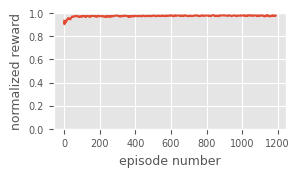

In [ ]:
plt.style.use('ggplot')
fig= plt.figure(figsize=(FigDim1,FigDim2))
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.xlabel('episode number', fontsize=9)  
plt.ylabel('normalized reward', fontsize=9) 
plt.plot(avg_rewards)
plt.ylim([0.0, 1])
if saveFigs==True:
    plt.savefig('Figures/Example1_avgReward.pdf',bbox_inches ="tight")
plt.show()


K = AGENT.get_action#get_action

with open('Data/StateFeedbackGainFunction.pkl', 'wb') as outp:
    pickle.dump(K, outp, pickle.HIGHEST_PROTOCOL)

#with open('StateFeedbackGainFunction.pkl', 'rb') as inp:
    #K1 = pickle.load(inp)

tensor([[0.0285]])


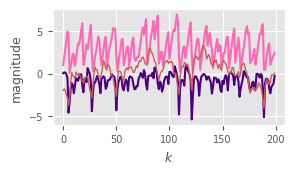

In [ ]:
T = 200

StateRec = deque([])
CovRec = deque([])
ActionRec = deque([])
StateRec_true = deque([])
Cov0 = 1 * torch.diag(torch.rand(rx,))
#Cov0[1,1]=torch.rand(1,) * 1
x0 = 5 * torch.randn(rx, 1)
#x0[2] = -26.667 + torch.randn(1,)
#x0[3] = 0.675 + 0.1 * torch.randn(1,)
#x0[4] = -2 + 0.2 * torch.randn(1,)
#x0[2] = abs(x0[2]) % (2*torch.pi)
#x0[2] = 2 + 0.5 * torch.randn(1,)
#x0[1] = 1 + 1.0 * torch.rand(1,)
print(x0)
Hyperstate.ChangeInitialStates(x0, Cov0)
true_state = Hyperstate.Mean + sqrtm(Hyperstate.Covariance) @ torch.randn(rx, 1) #we might need next t-step


for k in range(T):
    state = torch.cat((Hyperstate.Mean.T, torch.diag(Hyperstate.Covariance).unsqueeze(0)), dim=1)
    action = K(state)
    action = torch.atleast_2d(action.detach()).T
    true_state_Plus = stateDynamics(true_state, action) + sqrtm(Q_true) @ torch.randn(rx, 1)
    measurement_Plus_realization = measurementDynamics(true_state_Plus, action) + sqrtm(R) @ torch.randn(ry, 1)
    StateRec.append(Hyperstate.Mean)
    CovRec.append(Hyperstate.Covariance)
    ActionRec.append(action)
    StateRec_true.append(true_state)
    Hyperstate.ApplyEKF(action, measurement_Plus_realization)
    true_state = true_state_Plus
x = np.ones((rx, T))
x_true = np.ones((rx, T))
P = np.ones((rx ** 2, T))
for i in range(T):
    x[:,i] = StateRec[i].detach().numpy().squeeze()
    x_true[:,i] = StateRec_true[i].detach().numpy().squeeze()
    P[:,i] = CovRec[i].detach().numpy().squeeze().flatten()

plt.style.use('ggplot')
fig= plt.figure(figsize=(FigDim1,FigDim2))
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.xlabel('$k$', fontsize=9)  
plt.ylabel('magnitude', fontsize=9) 

k=56
plt.plot(range(T), x[0,:], color=list(colors.cnames)[k+4])
plt.plot(range(T), P[0,:], color=list(colors.cnames)[k+2])
plt.plot(range(T), x_true[0,:], linewidth = 1, color=list(colors.cnames)[k+3])
#fig= plt.figure(figsize=(FigDim1,FigDim2))
#plt.plot(x[0,:], x[1,:], '-.', linewidth = 1, color=list(colors.cnames)[k+3])
if saveFigs==True:
   plt.savefig('Figures/Example1_ReinfLearn.pdf',bbox_inches ="tight")


In [ ]:
T = 50

StateRec = deque([])
CovRec = deque([])
ActionRec = deque([])
StateRec_true = deque([])
Cov0 = 10 * torch.diag(torch.rand(rx,))
x0 = 5 * torch.randn(rx, 1)
#x0[1] = 2 + 0.5 * torch.randn(1,)
#x0[2] = 2 + 0.5 * torch.randn(1,)
Hyperstate.ChangeInitialStates(x0, Cov0)
true_state = Hyperstate.Mean + sqrtm(Hyperstate.Covariance) @ torch.randn(rx, 1) #we might need next t-step


for k in range(T):
    state = torch.cat((Hyperstate.Mean.T, torch.diag(Hyperstate.Covariance).unsqueeze(0)), dim=1)
    action = 1.0 * torch.randn(ru,) #-torch.from_numpy(Klqr) * Hyperstate.Mean   #torch.tensor([[0.0]]) #K(state)
    action = torch.atleast_2d(action.detach()).T
    true_state_Plus = stateDynamics(true_state, action) + sqrtm(Q_true) @ torch.randn(rx, 1)
    measurement_Plus_realization = measurementDynamics(true_state_Plus, action) + sqrtm(R) @ torch.randn(ry, 1)
    StateRec.append(Hyperstate.Mean)
    CovRec.append(Hyperstate.Covariance)
    ActionRec.append(action)
    StateRec_true.append(true_state)
    Hyperstate.ApplyEKF(action, measurement_Plus_realization)
    true_state = true_state_Plus
x = np.ones((rx, T))
x_true = np.ones((rx, T))
P = np.ones((rx ** 2, T))
for i in range(T):
    x[:,i] = StateRec[i].detach().numpy().squeeze()
    x_true[:,i] = StateRec_true[i].detach().numpy().squeeze()
    P[:,i] = CovRec[i].detach().numpy().squeeze().flatten()

plt.style.use('ggplot')
fig= plt.figure(figsize=(FigDim1,FigDim2))
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.xlabel('$k$', fontsize=9)  
plt.ylabel('magnitude', fontsize=9) 

k=56
plt.plot(range(T), x[0,:], color=list(colors.cnames)[k+4])
plt.plot(range(T), P[0,:], color=list(colors.cnames)[k+2])
plt.plot(range(T), x_true[0,:], linewidth = 1, color=list(colors.cnames)[k+3])
#plt.ylim([-20, 20])
if saveFigs==True:
   plt.savefig('Figures/Example1_LQR.pdf',bbox_inches ="tight")


In [ ]:
print(StateRec[0].detach().numpy())

In [ ]:
action_error = torch.randn(10,2)
print(action_error.sum(dim=1))

In [ ]:
u = torch.tensor([[1.0],[2.0]])
x = torch.tensor([[5.0, 1.0, 3.2]]).T
print(x[0])
print(stateDynamics(x, u))
print(f_Jacobian(x, u).trace())

In [ ]:
A = torch.rand(5,1)
print(A[1:3,:])

In [ ]:
print(torch.diag(Hyperstate.Covariance).unsqueeze(0))
print(Hyperstate.Mean.T)
print(torch.cat((Hyperstate.Mean.T, torch.diag(Hyperstate.Covariance).unsqueeze(0)), dim=1))

In [ ]:
Hyperstate.Covariance = Hyperstate.Covariance + -0.001
print(Hyperstate.Covariance)
sqrtm(Hyperstate.Covariance @ Hyperstate.Covariance)

In [ ]:
import torch
A = torch.rand(5, 1)
B = torch.tensor([1,2,3,4,1])
for j in reversed(range(5)):
    print(j)
print(A.shape)

In [ ]:
from torch.distributions import MultivariateNormal
action_mean = torch.tensor([[1, 2]])
cov_mat = torch.diag(torch.ones(2,))
print(action_mean, cov_mat)
dist = MultivariateNormal(action_mean, cov_mat)
Actions = torch.randn(10,2)
print(dist.entropy())

In [ ]:
time_step_k = torch.tensor([[1],[2],[1],[2]])
print((time_step_k == time_step_k.max()).sum())
print(time_step_k.shape[0])
print(time_step_k[-1,:])


In [ ]:
A = torch.ones(6,3)

print(A.mean(dim=1))